# SCIKIT-OPTIMIZE

El propósito de este notebook es presentar las funcionalidades de esta librería:
https://scikit-optimize.github.io/stable/

Aquí dejamos un artículo que explica de manera sencilla la Optimización Bayesiana: https://towardsdatascience.com/the-beauty-of-bayesian-optimization-explained-in-simple-terms-81f3ee13b10f

## Instalación:

In [3]:
#Alcanza con correr:
#pip install scikit-optimize

In [4]:
import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt

# importamos la libreria
import skopt

## Dataset

In [5]:
# Utilizaremos el dataset de Digits, que contiene 1797 ejemplos de digitos escritos a mano de 8x8 pixeles.
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.data.shape)

(1797, 64)


<Figure size 432x288 with 0 Axes>

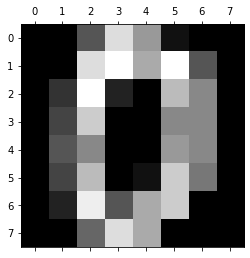

In [6]:
# Ejemplo
plt.gray() 
plt.matshow(digits.images[0]) 
plt.show() 

## Optimización Bayesiana

### Primer Ejemplo

In [7]:
# Para la optimización de hiperparámetros importamos la función BayesSearchCV, una versión
# bayesiana de RandomSearchCV de Scikit Learn.
from skopt import BayesSearchCV

#Como primer ejemplo, la documentación nos presenta una aplicación a un SVM
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

In [8]:
# Se divide el dataset en train y test
X, y = load_digits(n_class=10, return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=.25, random_state=0)

In [9]:
# Se instancia el modelo y se busca el mínimo de la función de pérdida a través de optimización bayesiana.
# Se establecen los posibles parámetros de búsqueda según el modelo de SVM.
# Tomamos de la documentación:

# log-uniform: understand as search over p = exp(x) by varying x
opt = BayesSearchCV(
    SVC(),
    {
        'C': (1e-6, 1e+6, 'log-uniform'),
        'gamma': (0.000001, 1, 'log-uniform'),
        'degree': (1, 8),  # integer valued parameter
        'kernel': ['linear', 'poly', 'rbf'],  # categorical parameter
    },
    n_iter=32,
    cv=3
)

In [10]:
%%time 
# Entrenamos el modelo y evaluamos el Score. Tomamos cuanto tiempo tarda en correr.

opt.fit(X_train, y_train)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))

ValueError: Not all points are within the bounds of the space.

In [11]:
## Importamos GridSearch para compara los tiempos.
from sklearn.model_selection import GridSearchCV

opt = GridSearchCV(
    SVC(),
    {
        'C': (1e-6, 1e+6, 'log-uniform'),
        'gamma': (0.000001, 1, 'log-uniform'),
        'degree': (1, 8),  # integer valued parameter
        'kernel': ['linear', 'poly', 'rbf'],  # categorical parameter
    },
    cv=3
)

In [12]:
%%time 
## Comparación con GridSearch sobre la misma búsqueda

opt.fit(X_train, y_train)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))

/Users/agustinramellodelavega/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/agustinramellodelavega/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/agustinramellodelavega/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/svm/_base.py", line 207, in fit
    "'auto'. Got '{}' instead.".format(self.gamma)
ValueError: When 'gamma' is a string, it should be either 'scale' or 'auto'. Got 'log-uniform' instead.

  FitFailedWarning)
/Users/agustinramellodelavega/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit fail

val. score: 0.9777282850779511
test score: 0.9711111111111111
CPU times: user 5.51 s, sys: 22.2 ms, total: 5.53 s
Wall time: 5.55 s


/Users/agustinramellodelavega/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/agustinramellodelavega/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/agustinramellodelavega/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/svm/_base.py", line 207, in fit
    "'auto'. Got '{}' instead.".format(self.gamma)
ValueError: When 'gamma' is a string, it should be either 'scale' or 'auto'. Got 'log-uniform' instead.

  FitFailedWarning)
/Users/agustinramellodelavega/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit fail

Primera Conclusión: Para modelos sencillos pareciera haber una pérdida de performace aunque arriba a un mejor resultado. No es de extrañar ya que esta herramienta tiene más sentido para funciones "blackbox" no lineales.

### Segundo ejemplo

Para el segundo ejemplo utlizamos un modelo de Random Forest para aumenar la cantidad de hiperparámetros a optimizar.

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [14]:
X, y = load_digits(n_class=10, return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=.25, random_state=0)

In [21]:
## Primero instanciamos el modelo de Random Forest bajo GridSearchCV para tener tener el benchmark.

opt = GridSearchCV(
    RandomForestClassifier(),
    {
        'n_estimators' : [10, 20, 30, 40, 50, 60, 80, 90, 100],
        'max_depth' : [3, 4, 5, 6, 7, 8, 9, 10, 15, 20],
        'min_samples_split' : [5, 10, 20, 50, 100],
        'random_state' : [0],
        'max_features': ['auto', 'sqrt', 'log2'],
        'criterion' :['gini', 'entropy']
    },
    cv=5
)

In [22]:
%%time
opt.fit(X_train, y_train)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))

val. score: 0.9762357152691724
test score: 0.9777777777777777
CPU times: user 20min 7s, sys: 6.26 s, total: 20min 13s
Wall time: 20min 13s


In [23]:
## Instanciamos lo mismo con BayesSearchCV
opt = BayesSearchCV(
    RandomForestClassifier(),
    {
        'n_estimators' : [10, 20, 30, 40, 50, 60, 80, 90, 100],
        'max_depth' : [3, 4, 5, 6, 7, 8, 9, 10, 15, 20],
        'min_samples_split' : [5, 10, 20, 50, 100],
        'random_state' : [0],
        'max_features': ['auto', 'sqrt', 'log2'],
        'criterion' :['gini', 'entropy']
    },
    n_iter=100,
    cv=5
)

In [24]:
%%time

#Corremos el modelo con Optimización Bayesiana
opt.fit(X_train, y_train)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))

/Users/agustinramellodelavega/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/agustinramellodelavega/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/agustinramellodelavega/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/agustinramellodelavega/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/agustinramellodel

val. score: 0.9755011135857461
test score: 0.9755555555555555
CPU times: user 15min 43s, sys: 1min 57s, total: 17min 41s
Wall time: 5min 7s


*Conclusión:* Podemos apreciar que con una performance muy similar, se ahorró cerca de un 25% del tiempo.